In [1]:
import os
while os.path.split(os.getcwd())[1] != "unrolling":
    os.chdir("..")
    if os.getcwd() == "/":
        raise ValueError()
print("Current working directory: {} \n".format(os.getcwd()))

import numpy as np
import matplotlib.pyplot as plt


import torch
from torch.utils.data import TensorDataset, DataLoader

import sys
PATH = './codes/'
sys.path.insert(1,PATH)
import IAE_CNN_TORCH_v2 as cnn
import GLPALM as GLPALM

from utils import generate_dataset_mixture

import pickle

if torch.cuda.is_available():
    device = 'cuda'
    kwargs = {}
    acc = "gpu"
    Xpus_per_trial = 1
else:
    device = 'cpu'
    kwargs = {}
    acc = 'cpu'
    Xpus_per_trial = 1

print("device USED: ",device)

Current working directory: /feynman/work/dedip/lilas/wf274757/unrolling 

device USED:  cuda


## Generating dataset

In [ ]:
def generate_dataset_mixture(model_IAE_list, nb_samples, noise_level=[1e-3, 1e-1], sigma_a = 0., eps=0.):
    ''' generate mixtures Y = AX + n where X belongs to a malifold learned by model_IAE 
        and n is a Gaussian noise
        model_IAE_list: provide the IEA models to sample sources components X
        noise_level: range of standard deviation of the gaussian noise
        sigma_a: variability of relative scaling between components
        eps: variability of global scaling
    '''

    X = []
    for model_IAE in model_IAE_list:
        if model_IAE.mean_lambda:
            lam = torch.rand((nb_samples, model_IAE.num_ap), device=model_IAE.device).repeat(model_IAE.NLayers,1,1)
        else:
            lam = torch.rand((model_IAE.NLayers, nb_samples, model_IAE.num_ap), device=model_IAE.device)
        lam = torch.einsum('ijk,ij->ijk', lam, 1. / torch.sum(lam, 2)) 
        X.append(model_IAE.get_barycenter(lam).detach().numpy())
    X = np.stack(X).transpose((1,0,2,3))

    if sigma_a=="inf": # a random [0,1]
        A = np.random.rand(X.shape[0],X.shape[1],X.shape[3]) / len(model_IAE_list) * 2.
    else:
        A = 1 / len(model_IAE_list) + sigma_a * np.random.randn(X.shape[0],X.shape[1],X.shape[3])
    A = projection_simplex(A[:,:,0], axis=1)[:,:,None]   

    if not eps==0.:
        A = np.einsum('ijl,i->ijl', A, ((1.+eps)*np.ones(X.shape[0]))**((np.random.rand(X.shape[0]))*2-1))

    sigma = 10 ** (np.random.rand(X.shape[0]) * (np.log10(noise_level[1]/noise_level[0])) + np.log10(noise_level[0]))
    Y = np.einsum('ijkl, ijl->ikl', X, A) + np.einsum('ijk,i->ijk', np.random.randn(X.shape[0],X.shape[2],X.shape[3]), sigma)
    return Y, A, X


def projection_simplex(V, z=1, axis=None):
    """
    Projection of x onto the simplex, scaled by z:
        P(x; z) = argmin_{y >= 0, sum(y) = z} ||y - x||^2
    z: float or array
        If array, len(z) must be compatible with V
    axis: None or int
        axis=None: project V by P(V.ravel(); z)
        axis=1: project each V[i] by P(V[i]; z[i])
        axis=0: project each V[:, j] by P(V[:, j]; z[j])
    """
    if axis == 1:
        n_features = V.shape[1]
        U = np.sort(V, axis=1)[:, ::-1]
        z = np.ones(len(V)) * z
        cssv = np.cumsum(U, axis=1) - z[:, np.newaxis]
        ind = np.arange(n_features) + 1
        cond = U - cssv / ind > 0
        rho = np.count_nonzero(cond, axis=1)
        theta = cssv[np.arange(len(V)), rho - 1] / rho
        return np.maximum(V - theta[:, np.newaxis], 0)

    elif axis == 0:
        return projection_simplex(V.T, z, axis=1).T

    else:
        V = V.ravel().reshape(1, -1)
        return projection_simplex(V, z, axis=1).ravel()

max amplitudes:  [0.66436893 0.64891844 0.63333955]
min amplitudes:  [0.03439054 0.01089463 0.        ]
mean amplitudes:  [0.33279731 0.33349946 0.33370323]
variance:  [0.00659744 0.00668649 0.00663208]
mean sum:  1.0


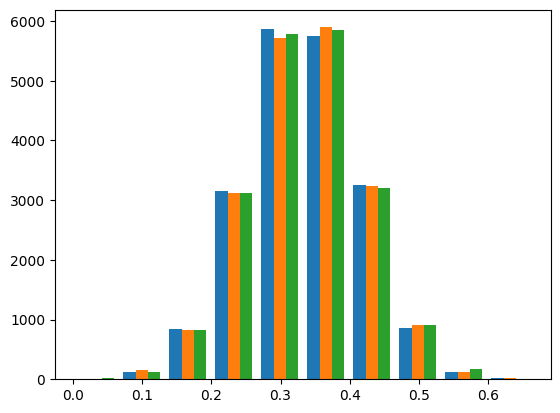

In [8]:
model_IAE_list = [
    cnn.load_model('Models/cnn_test'),
    cnn.load_model('Models/cnn_test2'),
    cnn.load_model('Models/cnn_test3')
]
sig = 0.1
eps = 0.
Y,A,X=generate_dataset_mixture(model_IAE_list, 20000, noise_level=[1e-3,1e-1],sigma_a=sig, eps=eps)
# with open('data/mixture_sigma'+str(sig)+'_scaling'+str(eps)+'.npy', "wb") as f:
#     pickle.dump([Y,A,X], f)
    

# with open('data/mixture_sigma'+str(sig)+'_scaling'+str(eps)+'.npy', "rb") as f:
#     Y, A, X = pickle.load(f)
    
plt.hist(A[:,:,0])
print('max amplitudes: ', A[:,:,0].max(0))
print('min amplitudes: ', A[:,:,0].min(0))
print('mean amplitudes: ', A[:,:,0].mean(0))
print('variance: ', A[:,:,0].var(0))
print('mean sum: ', A[:,:,0].sum(1).mean())

## Training GLPALM
- Launch **training.py** by <mark>sbatch python.sh</mark>
- Option: --Model", dest="model", default='GLPALM', help="GLPALM / LPALM" 
          --Dataset", dest="dataset", default='mixture_sigma0.1', help="dataset of different variablity of amplitude: sigma0 / sigma0.01/ sigma0.1/ sigmainf"
          --Batch_Size", dest="bs", type=int, default=64, help="Batch size"
          --learning_rate", dest="lr", type=float, default=1e-3, help="learning rate"
          --NLayers", dest="nlayers", type=int, default=2, help="number of layers",
          --lam_loss", dest="lam_loss", type=float, default=0., help="weight of amplitude-estimation error in the loss",
          --layers_weights", dest="layers_weights", default='last', help="type of loss control on intermediate layers: last, exp, ",
          --update_A", dest="update_A", default='LS', help="GD, LS, No-updating",
          --Version", dest="version", default=None, help="CNN",
          --W_shape", dest="W_shape", default='vector', help="W vector or matrix"

## Testing GLPALM

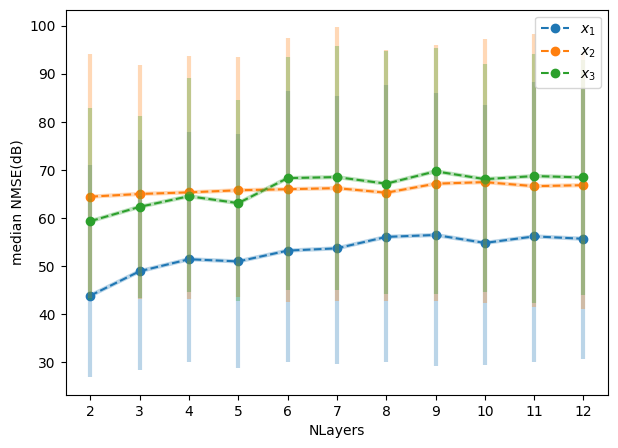

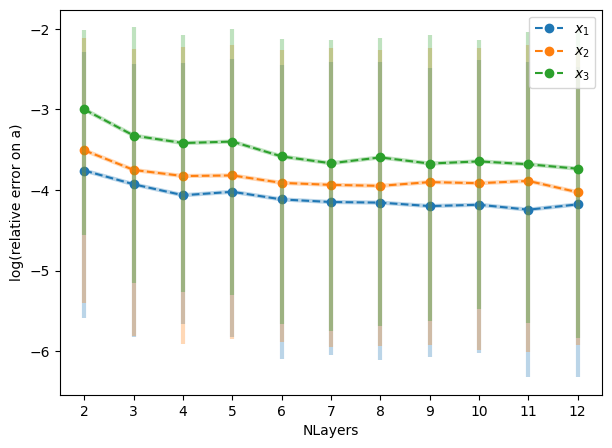

In [2]:
# number of layers
model_IAE_list = [
    cnn.load_model('Models/cnn_test'),
    cnn.load_model('Models/cnn_test2'),
    cnn.load_model('Models/cnn_test3'),
]

nb_samples=1000
sig=0.1
eps=1.0

Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, nb_samples, noise_level=[1e-3,1e-1],sigma_a=sig,eps=eps)
dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)

nmse_x=[]
err_a=[]

list_NLayers = np.arange(2,13)
for NLayers in list_NLayers:
    fname = 'Models/models0910/model_GLPALM_LS_CNN_L'+str(NLayers)+'_sigma'+str(sig)+'_scaling1.0'
    model = GLPALM.load_model(fname, device=device)
    model_name = fname[fname.find('GLFBS'):]
    Apred = []
    Xpred = []
    for data in dataloader:
        Y,A,X = data
        with torch.no_grad():
            Apred_batch, Lam_pred_batch = model.forward(Y.to(device))
        Apred_batch = Apred_batch[-1].cpu().detach().numpy()
        Xpred_batch = model.psi(Lam_pred_batch[-1]).cpu().detach().numpy()
        Apred.append(Apred_batch)
        Xpred.append(Xpred_batch)
    Apred = np.vstack(Apred)
    Xpred = np.vstack(Xpred)
    nmse_x.append(-20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3))))
    # nmse_x.append(np.mean(-20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3))),1))
    err_a.append(np.log((np.abs(Apred-Atest)/np.abs(Atest+1e-10)).squeeze()+1e-10))

perc=10
yerrs = np.abs(np.stack([np.percentile(np.stack(nmse_x),perc,axis=1),np.percentile(np.stack(nmse_x),100-perc,axis=1)])-np.median(np.stack(nmse_x), 1))
cmap = plt.get_cmap("tab10")
plt.figure(figsize=(7,5))
for i in range(3):
    plt.errorbar(list_NLayers, np.median(np.stack(nmse_x), 1)[:,i], yerr=yerrs[:,:,i],color=cmap(i), alpha=0.3,lw=3)
    plt.plot(list_NLayers, np.median(np.stack(nmse_x), 1)[:,i], '--o',label='$x_%d$'%(i+1))
plt.xticks(list_NLayers)
plt.xlabel('NLayers')
plt.ylabel('median NMSE(dB)')
plt.legend()
# plt.savefig('./Figures/lpalm_Nlayer_NMSE_sigma'+str(sig)+'_p.png', bbox_inches='tight')

plt.figure(figsize=(7,5))
yerrs = np.abs(np.stack([np.percentile(np.stack(err_a),perc,axis=1),np.percentile(np.stack(err_a),100-perc,axis=1)])-np.median(np.stack(err_a), 1))
for i in range(3):
    plt.errorbar(list_NLayers, np.median(np.stack(err_a), 1)[:,i], yerr=yerrs[:,:,i],color=cmap(i), alpha=0.3,lw=3)
    plt.plot(list_NLayers, np.median(np.stack(err_a), 1)[:,i], '--o',label='$x_%d$'%(i+1))
plt.xticks(list_NLayers)
plt.xlabel('NLayers')
plt.ylabel('log(relative error on a)')
plt.legend()
# plt.savefig('./Figures/lpalm_Nlayer_errA_sigma'+str(sig)+'_p.png', bbox_inches='tight')

In [4]:
# robustness w.r.t global scaling 

model_IAE_list = [
    cnn.load_model('Models/cnn_test'),
    cnn.load_model('Models/cnn_test2'),
    cnn.load_model('Models/cnn_test3'),
]
fnames_GLPALM = ['Models/model_GLPALM_LS_CNN_L6_sigma0.1',
                 'Models/models_scaling/model_GLPALM_LS_CNN_L7_sigma0.1_scaling0.1',
                 'Models/models_scaling/model_GLPALM_LS_CNN_L7_sigma0.1_scaling0.5',
                 'Models/models_scaling/model_GLPALM_LS_CNN_L7_sigma0.1_scaling1.0']
sig = 0.1
list_eps=[0.,0.1, 0.5, 1.0]
nmse_x_GLPALM=[]
err_a_GLPALM=[]

for i in range(4):
    Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 1000, noise_level=[1e-3,1e-1],sigma_a=sig, eps=list_eps[i])
    dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)
    fname = fnames_GLPALM[i]
    model = GLPALM.load_model(fname, device=device)
    model_name = fname[fname.find('GLFBS'):]
    Apred = []
    Xpred = []
    for data in dataloader:
        Y,A,X = data
        with torch.no_grad():
            Apred_batch, Lam_pred_batch = model.forward(Y.to(device))
        Apred_batch = Apred_batch[-1].cpu().detach().numpy()
        Xpred_batch = model.psi(Lam_pred_batch[-1]).cpu().detach().numpy()
        Apred.append(Apred_batch)
        Xpred.append(Xpred_batch)
    Apred = np.vstack(Apred)
    Xpred = np.vstack(Xpred)
    nmse_x_GLPALM.append(-20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3))))
    err_a_GLPALM.append(np.log((np.abs(Apred-Atest)/np.abs(Atest+1e-10)).squeeze()+1e-10))

cmap = plt.get_cmap("tab10")
i=0
plt.figure(figsize=(7,5))
perc=10
yerrs = np.abs(np.stack([np.percentile(np.stack(nmse_x_GLPALM),perc,axis=1),np.percentile(np.stack(nmse_x_GLPALM),100-perc,axis=1)])-np.median(np.stack(nmse_x_GLPALM), 1))
for i in range(3):
    plt.errorbar(np.arange(4),np.median(np.stack(nmse_x_GLPALM), 1)[:,i], yerr=yerrs[:,:,i],color=cmap(i), alpha=0.3,lw=3)
    plt.plot(np.arange(4),np.median(np.stack(nmse_x_GLPALM), 1)[:,i], '--o',label='$x_%d$'%(i+1))
plt.xticks(np.arange(4),list_eps)
plt.xlabel('$\epsilon$')
plt.ylabel('median NMSE(dB)')
plt.legend()
# plt.savefig('./Figures/robustness_GLPALM_sigma0.1.png', bbox_inches='tight')

plt.figure(figsize=(7,5))
yerrs = np.abs(np.stack([np.percentile(np.stack(err_a_GLPALM),perc,axis=1),np.percentile(np.stack(err_a_GLPALM),100-perc,axis=1)])-np.median(np.stack(err_a_GLPALM), 1))
for i in range(3):
    plt.errorbar(np.arange(4), np.median(np.stack(err_a_GLPALM), 1)[:,i], yerr=yerrs[:,:,i],color=cmap(i), alpha=0.3,lw=3)
    plt.plot(np.arange(4),np.median(np.stack(err_a_GLPALM), 1)[:,i], '--o',label='$x_%d$'%(i+1))
plt.xticks(np.arange(4),list_eps)
plt.xlabel('$\epsilon$')
plt.ylabel('log(relative error on a)')
plt.legend()
# plt.savefig('./Figures/robustness_GLPALM_errA_sigma0.1.png', bbox_inches='tight')


FileNotFoundError: [Errno 2] No such file or directory: 'Models/models_scaling/model_GLPALM_LS_CNN_L7_sigma0.1_scaling0.1.pth'

In [ ]:
# robustness w.r.t relative scaling 

fnames_GLPALM = ['Models/models_sigma/model_GLPALM_LS_CNN_L6_sigma0.01',
            'Models/models_sigma/model_GLPALM_LS_CNN_L6_sigma0.1',
            'Models/models_sigma/model_GLPALM_CNN_LS_L6_sigmainf']
list_sig = [0.01,0.1,'inf']    
nmse_x_LPALM=[]
nmse_x_GLPALM=[]
err_a_LPALM=[]
err_a_GLPALM=[]

for i in range(3):
    sig = list_sig[i]
    Ytest,Atest,Xtest=generate_dataset_mixture(model_IAE_list, 10, noise_level=[1e-3,1e-1],sigma_a=sig)
    dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)
    fname = fnames_GLPALM[i]
    model = GLPALM.load_model(fname, device=device)
    model_name = fname[fname.find('GLFBS'):]
    Apred = []
    Xpred = []
    for data in dataloader:
        Y,A,X = data
        with torch.no_grad():
            Apred_batch, Lam_pred_batch = model.forward(Y.to(device))
        Apred_batch = Apred_batch[-1].cpu().detach().numpy()
        Xpred_batch = model.psi(Lam_pred_batch[-1]).cpu().detach().numpy()
        Apred.append(Apred_batch)
        Xpred.append(Xpred_batch)
    Apred = np.vstack(Apred)
    Xpred = np.vstack(Xpred)
    nmse_x_GLPALM.append(-20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3))))
    err_a_GLPALM.append(np.log((np.abs(Apred-Atest)/np.abs(Atest+1e-10)).squeeze()+1e-10))

cmap = plt.get_cmap("tab10")
plt.figure(figsize=(7,5))
perc=10
yerrs = np.abs(np.stack([np.percentile(np.stack(nmse_x_GLPALM),perc,axis=1),np.percentile(np.stack(nmse_x_GLPALM),100-perc,axis=1)])-np.median(np.stack(nmse_x_GLPALM), 1))
for i in range(3):
    plt.errorbar(np.arange(3),np.median(np.stack(nmse_x_GLPALM), 1)[:,i], yerr=yerrs[:,:,i],color=cmap(i), alpha=0.3,lw=3)
    plt.plot(np.arange(3),np.median(np.stack(nmse_x_GLPALM), 1)[:,i], '--o',label='$x_%d$'%(i+1))
plt.xticks(np.arange(3),list_sig)
plt.xlabel('$\sigma$')
plt.ylabel('median NMSE(dB)')
plt.legend()
# plt.savefig('./Figures/robustness_GLPALM.png', bbox_inches='tight')

plt.figure(figsize=(7,5))
yerrs = np.abs(np.stack([np.percentile(np.stack(err_a_GLPALM),perc,axis=1),np.percentile(np.stack(err_a_GLPALM),100-perc,axis=1)])-np.median(np.stack(err_a_GLPALM), 1))
for i in range(3):
    plt.errorbar(np.arange(3), np.median(np.stack(err_a_GLPALM), 1)[:,i], yerr=yerrs[:,:,i],color=cmap(i), alpha=0.3,lw=3)
    plt.plot(np.arange(3),np.median(np.stack(err_a_GLPALM), 1)[:,i], '--o',label='$x_%d$'%(i+1))
plt.xticks(np.arange(3),list_sig)
plt.xlabel('$\sigma$')
plt.ylabel('log(relative error on a)')
plt.legend()
# plt.savefig('./Figures/robustness_GLPALM_errA.png', bbox_inches='tight')


## Training GLFBS
- particular case of GLPALM
- where **--update_A='No-updating'**

## Test GLFBS

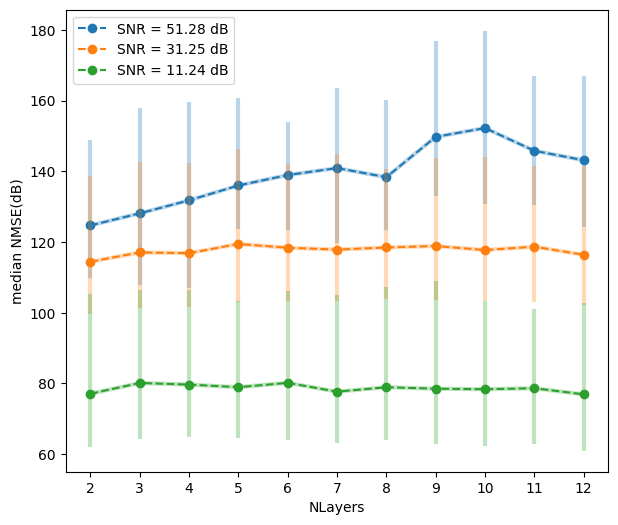

In [3]:
# number of layers

model_IAE_list = [
    cnn.load_model('Models/cnn_test'),
    cnn.load_model('Models/cnn_test2'),
    cnn.load_model('Models/cnn_test3'),
]

nb_samples=1000

cmap = plt.get_cmap("tab10")
plt.figure(figsize=(7,6))
i=0
perc=10
for noise in [1e-3,1e-2,1e-1]:
    Ytest,Atest,Xtest=generate_dataset_mixture([model_IAE_list[2]], nb_samples, noise_level=[noise,noise],sigma_a=0.)
    dataloader = DataLoader(TensorDataset(torch.from_numpy(Ytest).float(), torch.from_numpy(Atest).float(), torch.from_numpy(Xtest).float()), batch_size=1000)
    
    nmse_x=[]
    err_a=[]
    
    list_NLayers = np.arange(2,13)
    for NLayers in list_NLayers:
        fname = 'Models/models0907/model_GLFBS_CNN_L'+str(NLayers)+'_Cs137'
        model = GLPALM.load_model(fname, device=device)
        
        Apred = []
        Xpred = []
        for data in dataloader:
            Y,A,X = data
            with torch.no_grad():
                Apred_batch, Lam_pred_batch = model.forward(Y.to(device))
            Apred_batch = Apred_batch[-1].cpu().detach().numpy()
            Xpred_batch = model.psi(Lam_pred_batch[-1]).cpu().detach().numpy()
            Apred.append(Apred_batch)
            Xpred.append(Xpred_batch)
        Apred = np.vstack(Apred)
        Xpred = np.vstack(Xpred)
    
        nmse_x.append(-20*np.log10(((Xpred-Xtest)**2).sum((2,3))/(Xtest**2).sum((2,3))))
    plt.xticks(list_NLayers)
    signal = np.einsum('ijl,ijkl->ikl',Atest,Xtest)
    noise = Ytest - signal
    snr = 10*np.log10(((signal**2).sum(1) / (noise**2).sum(1)).mean())
    plt.plot(list_NLayers, np.median(np.stack(nmse_x), (1,2)), '--o', color=cmap(i), label='SNR = %.2f dB' % snr)
    yerrs = np.array([np.percentile(np.stack(nmse_x),perc,axis=1).squeeze(), np.percentile(np.stack(nmse_x),100-perc,axis=1).squeeze()])
    plt.errorbar(list_NLayers, np.median(np.stack(nmse_x), (1,2)), yerr=np.abs(yerrs-np.median(np.stack(nmse_x), (1,2))),color=cmap(i),alpha=0.3,lw=3)
    i+=1
plt.xlabel('NLayers')
plt.ylabel('median NMSE(dB)')
plt.legend(loc='upper left')
# plt.savefig('./Figures/lfbs_Nlayer_snr_perc.png', bbox_inches='tight')
